In [6]:
#Importing all the necessary libraries
import pandas as pd    
import numpy as np 
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import catboost
import matplotlib.pyplot as plt
from operator import itemgetter
import scipy
import string
import xgboost
from tqdm import tqdm
import xgbfir
from scipy import stats
from sklearn.ensemble import StackingRegressor
import optuna
import math
import itertools
import pickle
import warnings 
import seaborn as sns
import lightgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
from joblib import dump, load

global random_state
random_state = 42
warnings.filterwarnings('ignore')

In [18]:
X_train, X_test, y_train, y_test = pickle.load(open('train_test_split.pkl', 'rb'))

In [21]:
estimator = load('estimator.joblib')

In [22]:
pred = estimator.predict(X_test)
pred = [decode_log_200(x) for x in pred]
y_test['pred'] = pred
mae(y_test['loss'],pred)

1122.9672055718056

In [23]:
y_test.head()

,loss,normalized_log_loss,log_200,loss_tranform,log_loss_transform,log_100,loss_d10,log_d10,loss_tranform_50,log_loss_transform_50,binned,pred
9209,4235.59,0.700456,8.397416,8.067305,8.067781,8.374613,0.002361,-6.048693,65.081411,4.175757,79.0,2696.583071
107459,2776.62,0.662732,7.998544,7.259039,7.259692,7.964371,0.003602,-5.626405,52.693643,3.964675,63.0,2154.155580
154859,887.13,0.560843,6.991296,5.457539,5.459076,6.894802,0.011272,-4.485406,29.784728,3.394559,14.0,1232.208532
119693,4509.23,0.706049,8.457280,8.194559,8.195013,8.435816,0.002218,-6.111297,67.150800,4.207052,81.0,5153.293064
77397,4880.69,0.713122,8.533202,8.358345,8.358773,8.513324,0.002049,-6.190457,69.861935,4.246623,83.0,1758.444855


In [24]:
#if difference between pred and loss is > 1100 then 1 else 0
#Threshold is set to 1100 as our MAE of test data is around 1100
y_test['diff'] = y_test['pred'] - y_test['loss']
y_test['type'] = y_test['diff'].apply(lambda x: 1 if np.abs(x) > 1100 else 0)
y_test.head()

,loss,normalized_log_loss,log_200,loss_tranform,log_loss_transform,log_100,loss_d10,log_d10,loss_tranform_50,log_loss_transform_50,binned,pred,diff,type
9209,4235.59,0.700456,8.397416,8.067305,8.067781,8.374613,0.002361,-6.048693,65.081411,4.175757,79.0,2696.583071,-1539.006929,1
107459,2776.62,0.662732,7.998544,7.259039,7.259692,7.964371,0.003602,-5.626405,52.693643,3.964675,63.0,2154.155580,-622.464420,0
154859,887.13,0.560843,6.991296,5.457539,5.459076,6.894802,0.011272,-4.485406,29.784728,3.394559,14.0,1232.208532,345.078532,0
119693,4509.23,0.706049,8.457280,8.194559,8.195013,8.435816,0.002218,-6.111297,67.150800,4.207052,81.0,5153.293064,644.063064,0
77397,4880.69,0.713122,8.533202,8.358345,8.358773,8.513324,0.002049,-6.190457,69.861935,4.246623,83.0,1758.444855,-3122.245145,1


In [25]:
#Summary Statistics on difference between pred and ground truth
y_test[y_test['type'] == 1]['diff'].describe()

count     6066.000000
mean     -1165.588727
std       3025.336004
min     -51116.249953
25%      -2580.136576
50%      -1489.185379
75%       1341.568159
max      12888.756598
Name: diff, dtype: float64

<AxesSubplot:>

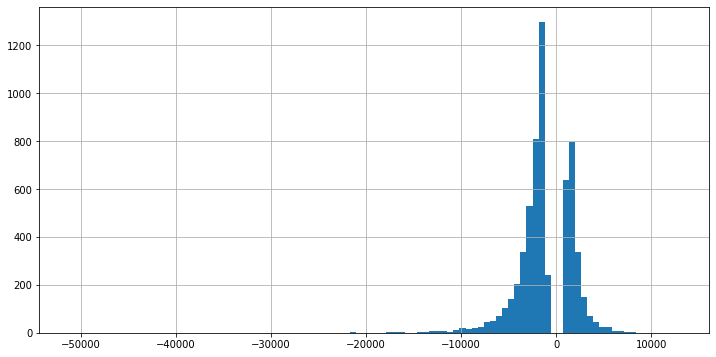

In [26]:
#plot histogram of loss where pred is 1 i.e incorrect points
#increase pandas plot size to see the plot
plt.rcParams['figure.figsize'] = (12, 6)
y_test[y_test['type'] == 1]['diff'].hist(bins=100)

<AxesSubplot:xlabel='diff', ylabel='Density'>

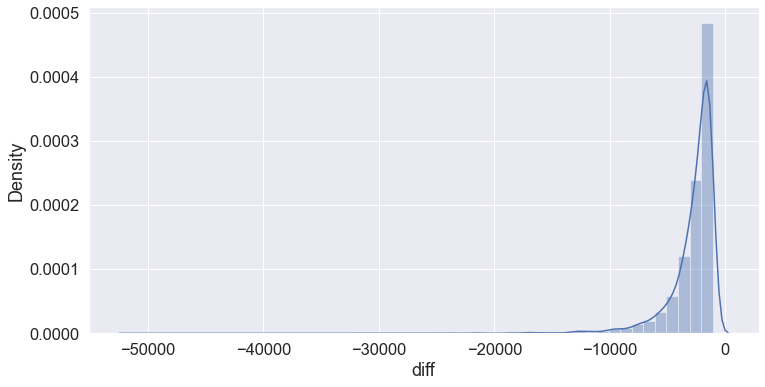

In [50]:
#pdf of prediction difference where model output under predicted i.e predicted value is less then the ground truth
neg_diff = y_test[(y_test['type'] == 1) & (y_test['diff'] < 0)]
sns.distplot(neg_diff['diff'])

In [28]:
#Summary Statistics
neg_diff['diff'].describe()

count     3963.000000
mean     -2825.471559
std       2345.196384
min     -51116.249953
25%      -3255.212952
50%      -2137.762410
75%      -1518.498242
max      -1100.103052
Name: diff, dtype: float64

In [29]:
#0-1 percentile on neg diff
for i in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    print(i, ":", np.percentile(neg_diff['diff'], i))

0 : -51116.2499534411
0.1 : -21245.067675462575
0.2 : -17254.035693838865
0.3 : -16649.2473111349
0.4 : -15202.988365621768
0.5 : -13605.940761360622
0.6 : -13068.033559420619
0.7 : -12763.475362579684
0.8 : -12629.120221062745
0.9 : -12257.2766654934
1 : -11727.656807999343


In [30]:
#Over here we can see that there are some big outliers points where diff is negative between pred and loss

<AxesSubplot:xlabel='diff', ylabel='Density'>

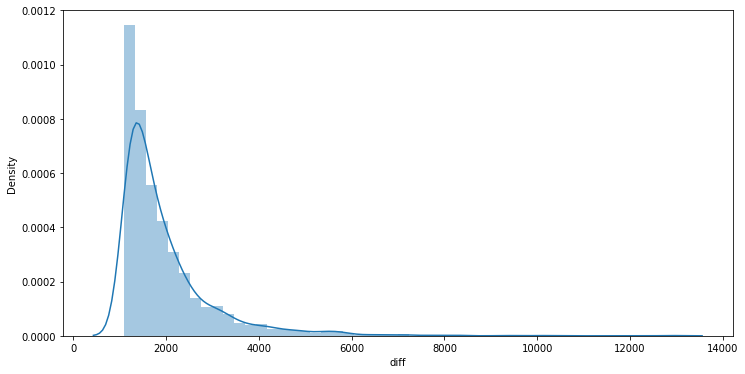

In [31]:
#pdf of prediction difference where model output is over predicted i.e predicted value is more then the ground truth
pos_diff = y_test[(y_test['type'] == 1) & (y_test['diff'] > 0)]
#plot sns distrib of pos diff
sns.distplot(pos_diff['diff'])

In [32]:
#Summary Statistics
pos_diff['diff'].describe()

count     2103.000000
mean      1962.378778
std       1028.853654
min       1100.013487
25%       1317.158105
50%       1619.897233
75%       2192.800662
max      12888.756598
Name: diff, dtype: float64

In [33]:
#Positive difference percentile
for i in range(0,110,10):
    print(i, ":", np.percentile(pos_diff['diff'], i))

0 : 1100.0134865847172
10 : 1181.6368499051528
20 : 1262.271794193867
30 : 1362.6190359108239
40 : 1487.557147973602
50 : 1619.8972332161538
60 : 1819.8647229171593
70 : 2053.5736339047376
80 : 2413.3092179668406
90 : 3138.100493642901
100 : 12888.756598008824


In [34]:

for i in range(90,101):
    print(i, ":", np.percentile(pos_diff['diff'], i))

90 : 3138.100493642901
91 : 3251.5985647630587
92 : 3389.67339613982
93 : 3538.8173076504672
94 : 3766.4109659934647
95 : 4028.699915749796
96 : 4254.619318088115
97 : 4713.161647168706
98 : 5291.863964701502
99 : 5843.535937389475
100 : 12888.756598008824


In [35]:
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i, ":", np.percentile(pos_diff['diff'], i))

99.1 : 5883.509921406547
99.2 : 6010.6845348582065
99.3 : 6364.49911259332
99.4 : 6576.216252182637
99.5 : 6866.350472135718
99.6 : 7098.742347456011
99.7 : 7482.306530825544
99.8 : 8130.971428640659
99.9 : 9227.58760358442
100 : 12888.756598008824


In [ ]:
#Over here in the positive difference we can see that 99% of the point have diff of less then 5800, only 1% of the point have diff of more then 5800
#So we can considered these 1% point as outliers

In [53]:
#Choosing only those points where ground truth is more than 4000
thres = 4000
high_correct = y_test[(y_test['loss'] > thres) & (y_test['type'] == 0)]
high_incorrect = y_test[(y_test['loss'] > thres) & (y_test['type'] == 1)]
df = pd.concat([high_correct, high_incorrect])
df.shape

(4475, 14)

<AxesSubplot:xlabel='loss', ylabel='Density'>

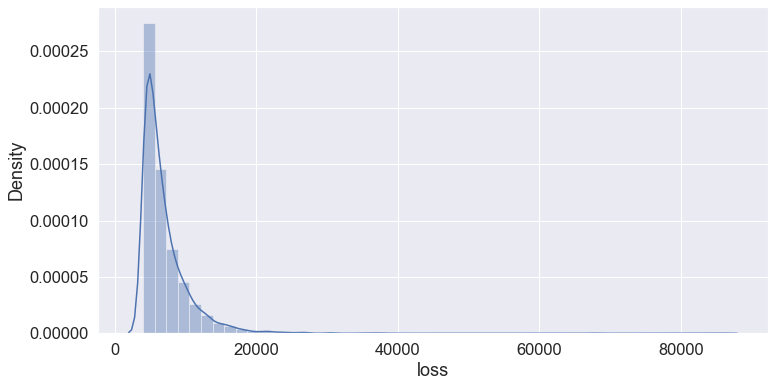

In [52]:
#plot pdf on loss column 
sns.distplot(df['loss'])

In [55]:
#Getting test data where ground truth is more than 4000
temp_test = X_test.copy()
temp_test = temp_test.loc[df.index]
temp_test['pred'] = df['pred']
temp_test['loss'] = df['loss']
temp_test['diff'] = df['diff']
temp_test.shape

(4475, 204)

In [57]:
neg_error = 0
pos_error = 0
for index, row in temp_test.iterrows():
    if np.abs(row['diff']) > 1000:
        if row['diff'] < 0:
            neg_error += 1
        else:
            pos_error += 1

print(f'Error Ratio when loss is greater then {thres}')
print("Negative error: ", neg_error)
print("Positive error: ", pos_error)


Error Ratio when loss is greater then 4000
Negative error:  2939
Positive error:  365


In [39]:
#We can see that when our original target i.e loss is greater then 4000, then our model make lost of negative errors
#i.e Our model prediction is less then loss and differs by more then 1000

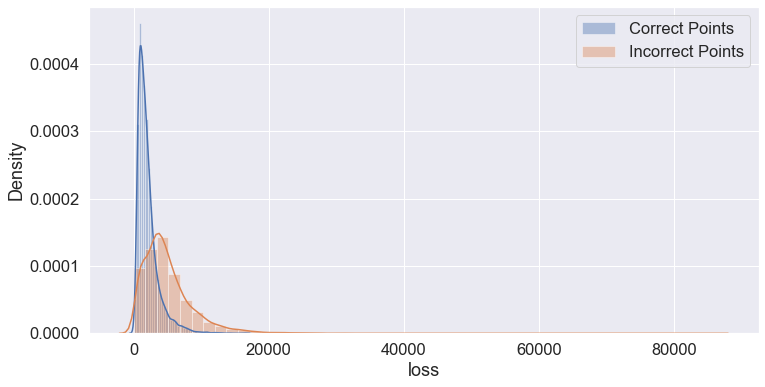

In [59]:
#pdf on incorrect and correct predictions
#sns display label 
sns.distplot(y_test[y_test['type'] == 0]['loss'], label='Correct Points')
sns.distplot(y_test[y_test['type'] == 1]['loss'], label='Incorrect Points')
plt.legend()

In [60]:
#There is a hge overlap between the two pdf's, but still we can notice that for bigger loss values, 
#our model predicted values have
#difference of more than 1100